# Some visualization of different emotions from Toronto emotional speech set

## Dataset: https://tspace.library.utoronto.ca/handle/1807/24487
#### Dataset structure: 7 folders (categories) containing wav files

#### Used data preprocessing example from 
#### https://www.kaggle.com/davids1992/speech-representation-and-data-exploration/notebook

In [1]:
import os

from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft

import numpy as np

import matplotlib.pyplot as plt

import librosa.display

import IPython.display as ipd

In [2]:
DATASET = './datasets/toronto/'

categories = [name for name in os.listdir(DATASET) if os.path.isdir(DATASET+name)]
print ('Categories:', categories)
for category in categories:
    print (category, len(os.listdir(DATASET+category)))


Categories: ['Neutral', 'Pleasant Surprise', 'Sad', 'Angry', 'Fear', 'Disgust', 'Happy']
Neutral 400
Pleasant Surprise 400
Sad 400
Angry 400
Fear 400
Disgust 400
Happy 400


In [3]:
sample_name = os.listdir(DATASET+categories[0])[0]
print (sample_name)
sample_rate, sample = wavfile.read(DATASET+categories[0]+'/'+sample_name)
print (sample_rate, len(sample))

OAF_fall_neutral.wav
24414 50007


In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

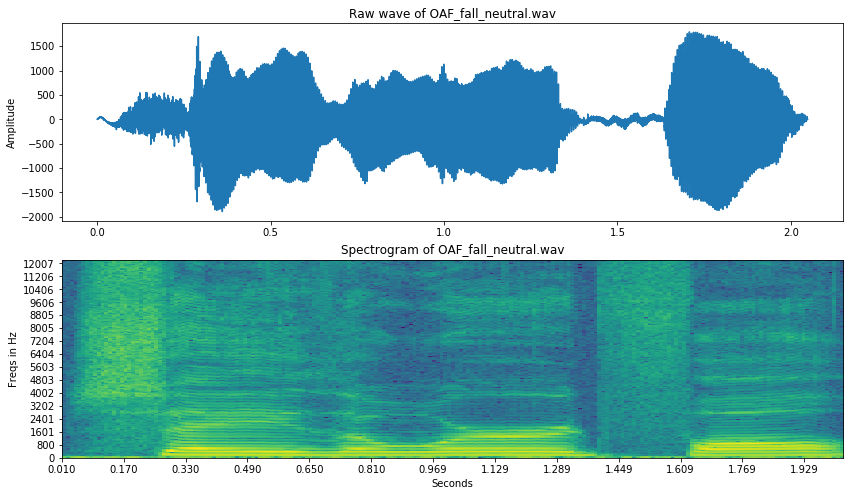

In [5]:
freqs, times, spectrogram = log_specgram(sample, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + sample_name)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(sample)/sample_rate, len(sample)), sample)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + sample_name)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

plt.show()

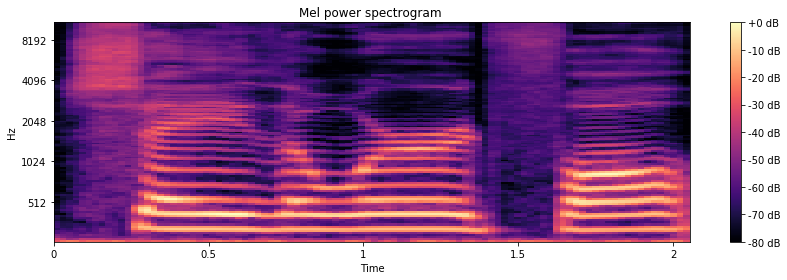

In [6]:
S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.show()

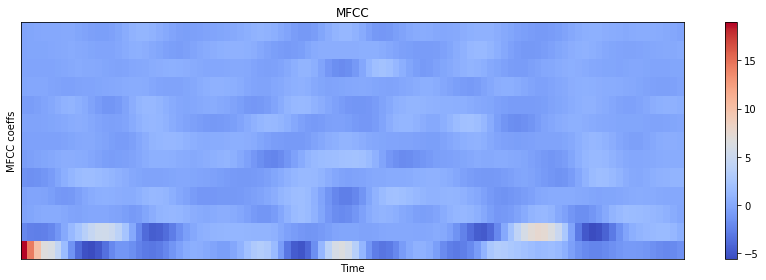

In [7]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

plt.show()

In [8]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  
    return xf, vals

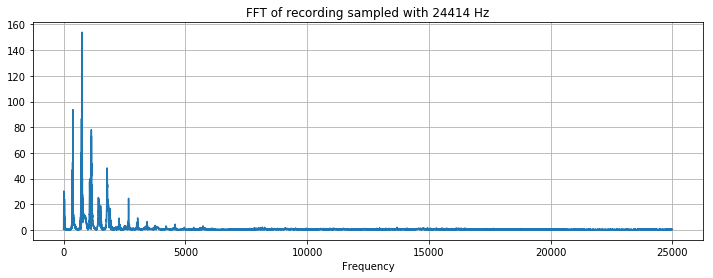

In [9]:
xf, vals = custom_fft(sample, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(range(int(len(sample)/2)), vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

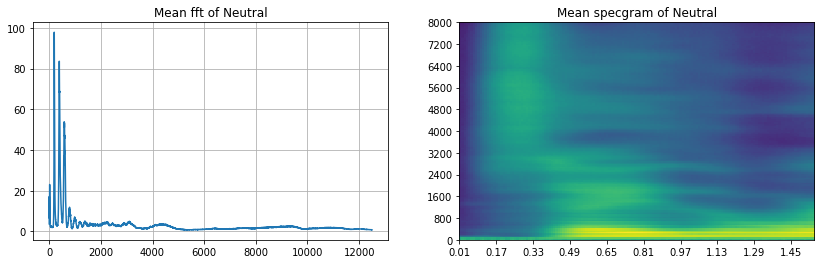

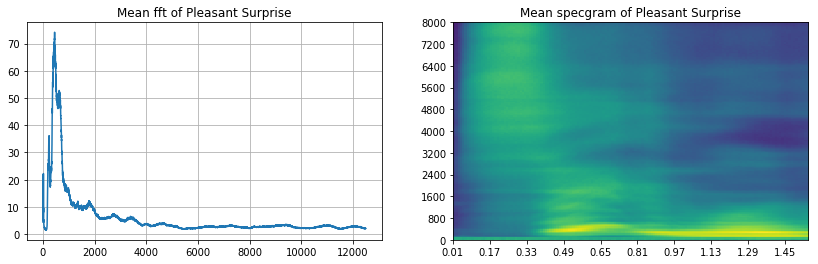

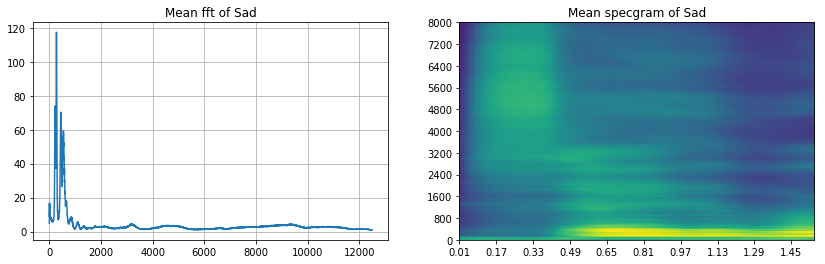

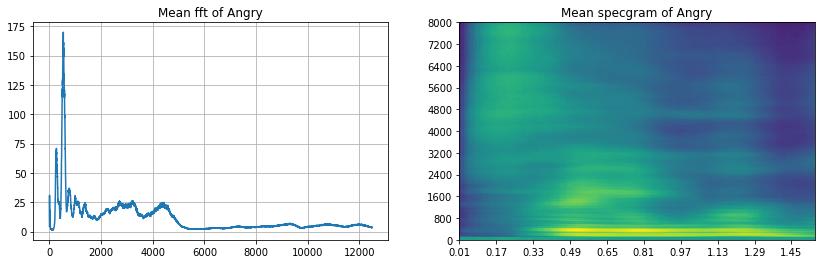

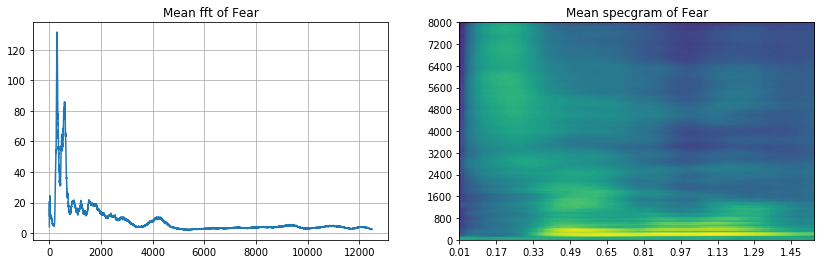

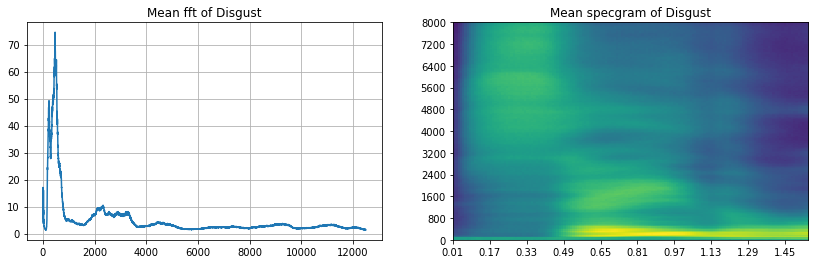

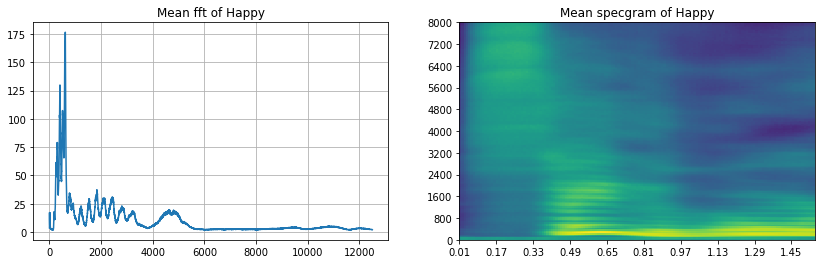

In [10]:
for category in categories:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(DATASET+category)if f.endswith('.wav')]
    for wav in waves:
        try:
            sample_rate, sample = wavfile.read(DATASET+category + '/' + wav)
        except ValueError:
            continue
        sample = sample[:25000]
        xf, vals = custom_fft(sample, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(sample, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + category)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + category)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

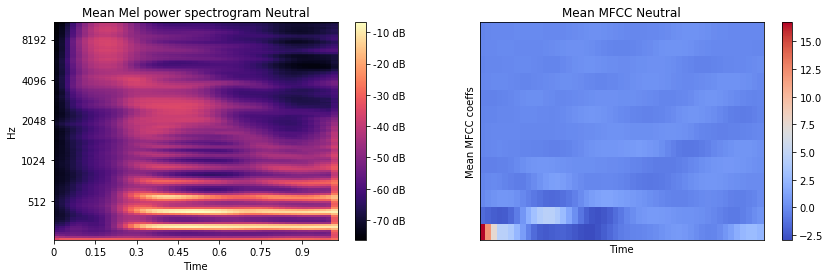

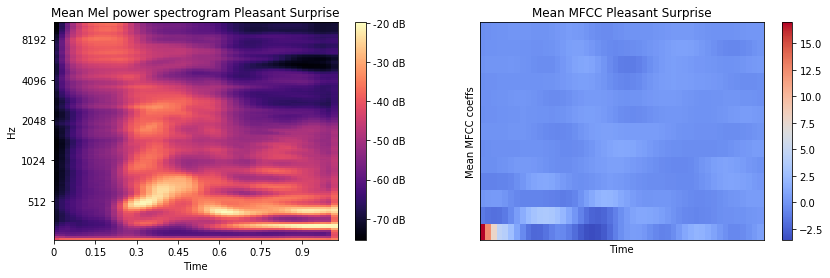

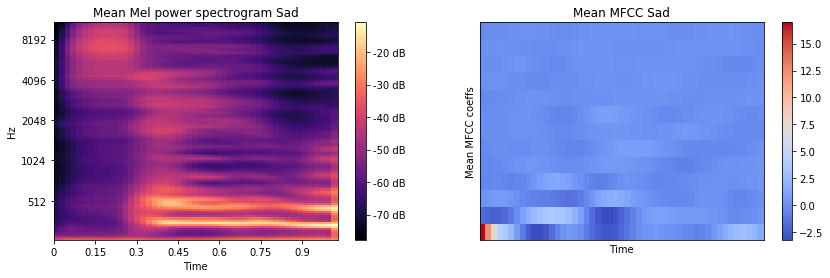

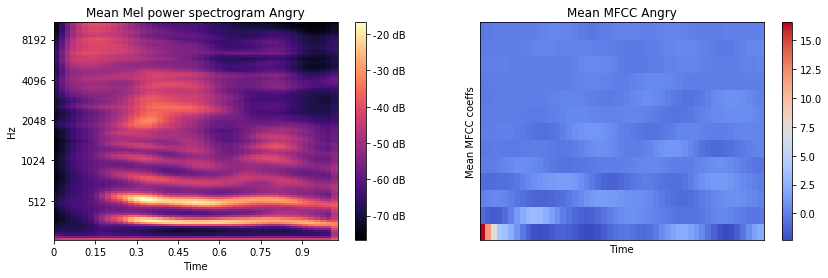

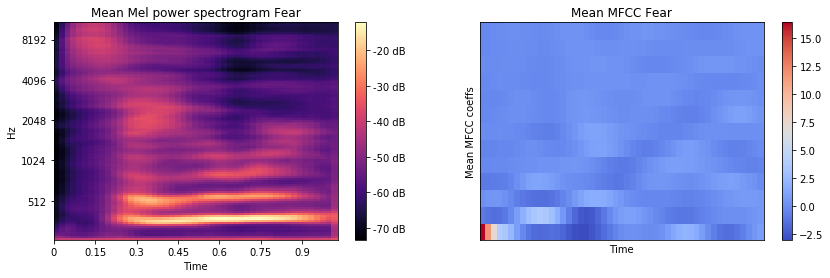

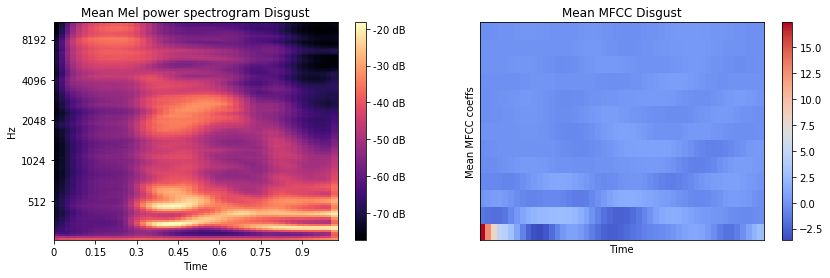

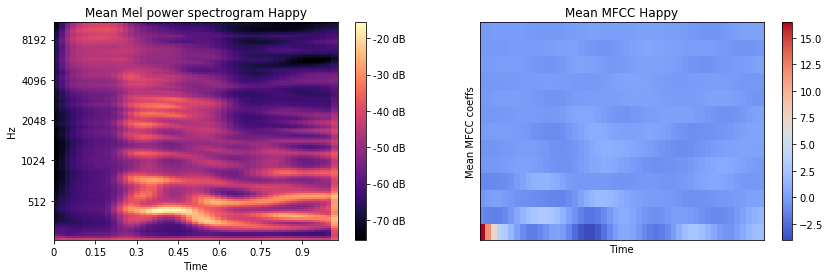

In [11]:
for category in categories:
    mel_spec_all = []
    mfcc_all = []

    waves = [f for f in os.listdir(DATASET+category)if f.endswith('.wav')]
    for wav in waves:
        try:
            sample_rate, sample = wavfile.read(DATASET+category + '/' + wav)
        except ValueError:
            continue
        sample = sample[:25000]

        
        S = librosa.feature.melspectrogram(sample, sr=sample_rate, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)
        mel_spec_all.append(log_S)
        
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        mfcc_all.append(delta2_mfcc)        
    
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    librosa.display.specshow(np.mean(np.array(mel_spec_all), axis=0), sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mean Mel power spectrogram '+ category)
    plt.colorbar(format='%+02.0f dB')

    plt.subplot(122)
    librosa.display.specshow(np.mean(np.array(mfcc_all), axis=0))
    plt.ylabel('Mean MFCC coeffs')
    plt.xlabel('Time')
    plt.title('Mean MFCC '+ category)
    plt.colorbar()
    
    plt.show()